<a href="https://colab.research.google.com/github/amir-jafari/SOM/blob/main/examples/NNSOM_Mnist_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --upgrade NNSOM


Importing libries

In [4]:
from NNSOM.som import SOM
import numpy as np
import pickle
from datetime import datetime
from scipy.spatial.distance import cdist
import pandas as pd
from sklearn.datasets  import load_digits
import matplotlib.pyplot as plt
import os
from sklearn.datasets import load_digits
from keras.datasets import mnist
from numpy.random import default_rng

Setting Parameters / Flags

In [5]:
# Flag to initialize the som (True), or load previously initialized (False)
Init_Flag = True
# Flag to save initialized model
Init_Save_Flag = False
# Flag to train the som, or load previously trained
Train_Flag = True
# Flag to save trained model
Save_SOM_Flag = False

In [6]:
# Set parameters
SOM_Row_Num = 8
Dimensions = (SOM_Row_Num, SOM_Row_Num)
Epochs = 1000
Steps = 100
Init_neighborhood = 3
SEED = 1234567
rng = default_rng(SEED)

image_index = 5000

Loading dataset

In [7]:
# digits = load_digits()

# load mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Data Preprocess

In [8]:
# x_train = digits.data
# y_train = digits.target

print(type(x_train))
print(type(y_train))

print(x_train.shape)
print(y_train.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(60000, 28, 28)
(60000,)


<Figure size 640x480 with 0 Axes>

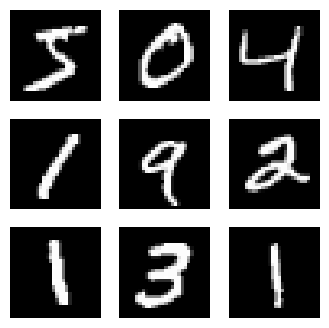

In [9]:
#plt.gray()
#plt.figure(figsize=(4, 4))
#for i in range(9):
    #plt.subplot(3, 3, i+1)
    #plt.imshow(x_train[i].reshape(8, 8))
    #plt.axis('off')

plt.gray()
plt.figure(figsize=(4, 4))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i])
    plt.axis('off')

In [10]:
for i in range(9):
    print(y_train[i])

# count each classes
for i in range(10):
    print(np.count_nonzero(y_train == i))

5
0
4
1
9
2
1
3
1
5923
6742
5958
6131
5842
5421
5918
6265
5851
5949


Reduce sample size like 200 images for each

In [11]:
# Reduce sample size like 200 image for each
x_train = x_train[:image_index]
y_train = y_train[:image_index]

print(x_train.shape)
print(y_train.shape)

# count each classes
for i in range(10):
    print(np.count_nonzero(y_train == i))

(5000, 28, 28)
(5000,)
479
563
488
493
535
434
501
550
462
495


In [12]:
print(x_train.min())
print(x_train.max())

0
255


In [13]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print(x_train.min())
print(x_train.max())
print(x_test.min())
print(x_test.max())

0.0
1.0
0.0
1.0


In [14]:
# Reshape (1000, 28, 28) to (1000, 28*28)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print(x_train.shape)
print(x_test.shape)

(5000, 784)
(10000, 784)


In [15]:
X_train = x_train
print(X_train.shape)

X = np.transpose(X_train)
print(X.shape)

(5000, 784)
(784, 5000)


Training

In [16]:
som_net = SOM(Dimensions)
som_net.init_w(X)
som_net.train(X, Init_neighborhood, Epochs, Steps)

Beginning Initialization
Current Time = 16:02:04
Ending Initialization
Current Time = 16:02:24
Beginning Training
Current Time = 16:02:24
50
Current Time = 16:02:49
100
Current Time = 16:03:04
150
Current Time = 16:03:19
200
Current Time = 16:03:34
250
Current Time = 16:03:50
300
Current Time = 16:04:05
350
Current Time = 16:04:20
400
Current Time = 16:04:35
450
Current Time = 16:04:50
500
Current Time = 16:05:05
550
Current Time = 16:05:20
600
Current Time = 16:05:35
650
Current Time = 16:05:50
700
Current Time = 16:06:06
750
Current Time = 16:06:21
800
Current Time = 16:06:36
850
Current Time = 16:06:51
900
Current Time = 16:07:07
950
Current Time = 16:07:22
1000
Current Time = 16:07:37
Ending Training
Current Time = 16:07:37


In [17]:
# Compute statistics
# Distance between each input and each weight
x_w_dist = cdist(som_net.w, np.transpose(X), 'euclidean')

# Find the index of the weight closest to the input
ind1 = np.argmin(x_w_dist,axis=0)

shapw = som_net.w.shape
S = shapw[0]
shapx = X.shape
Q = shapx[1]
net_ones = np.ones(S)
same_size = 100*np.ones(S)

Clust = []
dist = []
mdist = np.zeros(S)
clustSize = []

for i in range(S):
    # Find which inputs are closest to the current weight (in cluster i)
    tempclust = np.where(ind1==i)[0]

    # Save distance of each input in the cluster to cluster center (weight)
    tempdist = x_w_dist[i, tempclust]
    indsort = np.argsort(tempdist)
    tempclust = tempclust[indsort]
    tempdist = tempdist[indsort]

    # Add to distance array sorted distances
    dist.append(tempdist)

    # Add to Cluster array sorted indices
    Clust.append(tempclust)

    # Cluster size
    num = len(tempclust)
    clustSize.append(num)

    # Save the maximum distance to any input in the cluster from cluster center
    if num>0:
        mdist[i] = tempdist[-1]

# Find quantization error
quant_err = np.array([ 0 if len(item)==0 else np.mean(item) for item in dist]).mean()
print('Quantization error = ' + str(quant_err))

# Topological Error - Percent inputs where closest center and next closest center
# are not neighbors
ndist = som_net.neuron_dist
sort_dist = np.argsort(x_w_dist,axis=0)
top_dist = [ndist[sort_dist[0,ii],sort_dist[1,ii]] for ii  in range(sort_dist.shape[1])]
neighbors = np.where(np.array(top_dist)>1.1)
top_error = 100*len(neighbors[0])/x_w_dist.shape[1]
print('Topological Error (1st neighbor) = ' + str(top_error) + '%')
neighbors = np.where(np.array(top_dist)>2.1)
top_error = 100*len(neighbors[0])/x_w_dist.shape[1]
print('Topological Error (1st and 2nd neighbor) = ' + str(top_error) + '%')


# Distortion
dd = [1, 2, 3] # neighborhood distances
ww = som_net.w
wwdist = cdist(ww, ww, 'euclidean')
sst  = ndist[:, ind1]
for d in dd:
    factor1 = 2*d*d
    factor2 = Q*d*np.sqrt(2*np.pi)
    temp = np.exp(-np.multiply(sst,sst)/factor1)
    distortion = np.sum(np.multiply(temp,x_w_dist))/factor2
    print('Distortion (d='+str(d)+') = ' + str(distortion))

Quantization error = 5.5226181110217
Topological Error (1st neighbor) = 12.64%
Topological Error (1st and 2nd neighbor) = 1.96%
Distortion (d=1) = 16.32134554618802
Distortion (d=2) = 28.38369278800096
Distortion (d=3) = 33.52944872075512


Plotting: matplotlib

Plot the topology

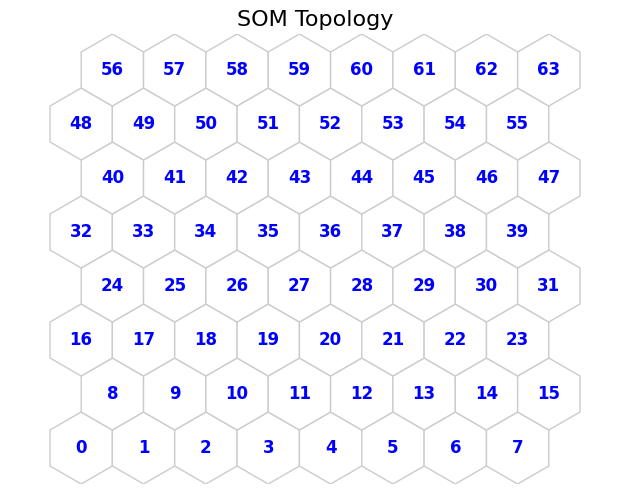

In [18]:
fig, ax, pathces, text = som_net.plt_top_num()
plt.title("SOM Topology", fontsize=16)
plt.show()

Plot the hit histogram

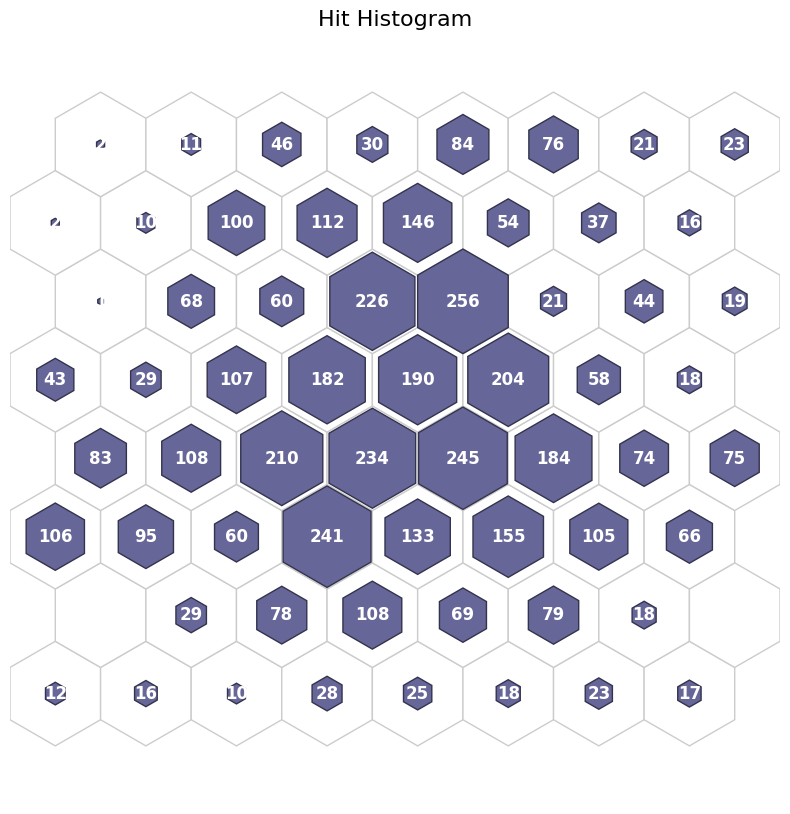

In [19]:
fig, ax, pathces, text = som_net.hit_hist(X, True)
plt.title("Hit Histogram", fontsize=16)
plt.show()

Plot distance between clusters

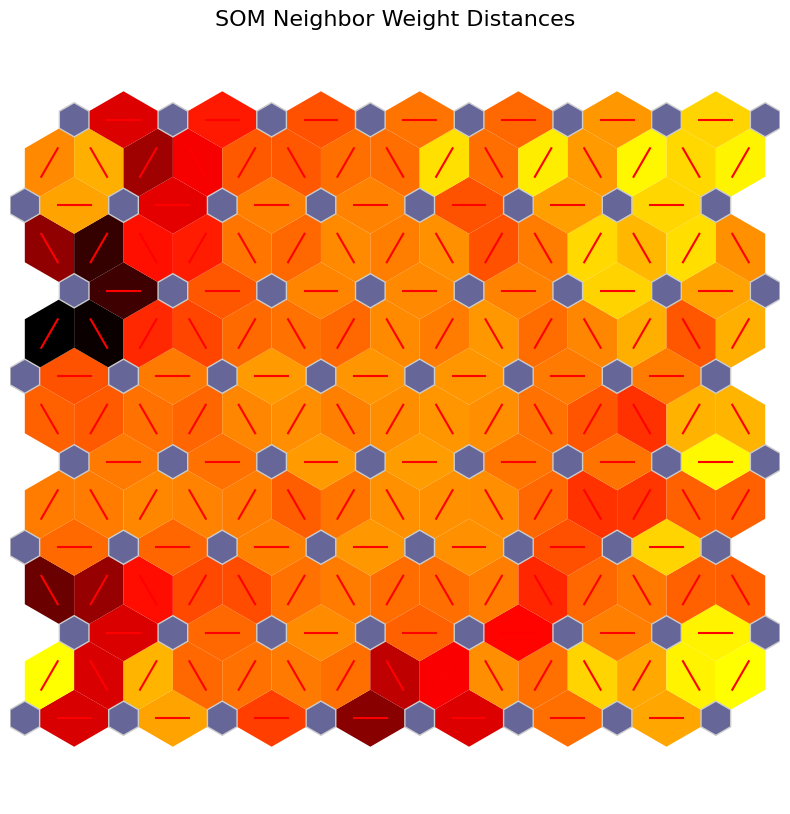

In [20]:
fig, ax, pathces = som_net.neuron_dist_plot()
plt.title("SOM Neighbor Weight Distances", fontsize=16)
plt.show()

Simple Grid

/usr/local/lib/python3.10/dist-packages/NNSOM/som.py:1015: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ticktext)


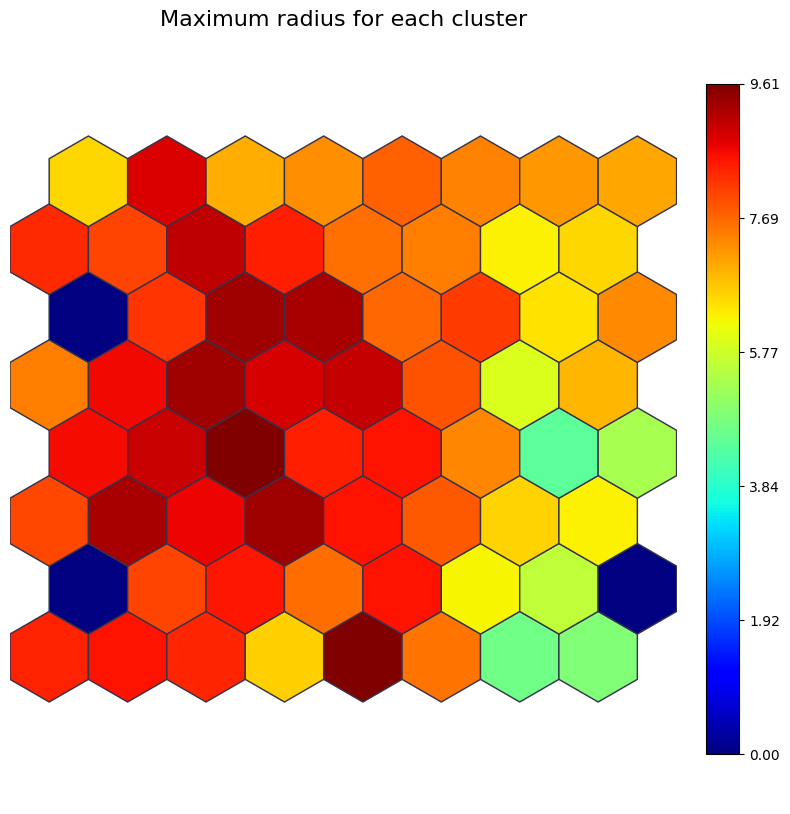

In [21]:
fig, ax, patches, cbar = som_net.simple_grid(mdist, net_ones)
plt.title("Maximum radius for each cluster", fontsize=16)
plt.show()

(64, 784)


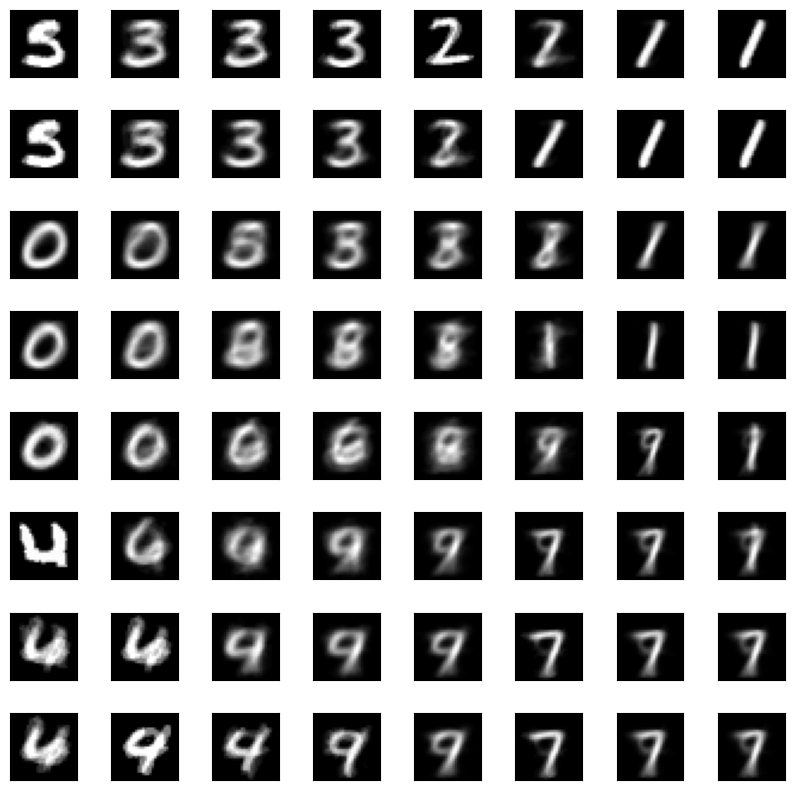

In [25]:
ww = som_net.w
print(ww.shape)

data = ww

# Assuming `data` is your numpy array with shape (64, 784)
# Reshape data to (64, 28, 28) to make it easier to handle
images = data.reshape(-1, 28, 28)

# Set up the figure size and grid
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))

# Adjust layout
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, ax in enumerate(axes.flat):
    # Display image
    ax.imshow(images[i], cmap='gray')

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Show the plot
plt.show()